In [12]:
import requests
import pandas as pd

url = "https://file.notion.so/f/f/f3d54618-4ee1-480d-b8f7-25c361e2c7b2/12d14740-f5b4-4ce9-9d4d-b9d0b3cd5548/data.parquet?table=block&id=6fa5d867-4063-4844-aebb-4be60a25af39&spaceId=f3d54618-4ee1-480d-b8f7-25c361e2c7b2&expirationTimestamp=1764540000000&signature=2xy3o7ivVOYY4USkTb-wD04RaXTg8a8osCbJWH6usaw&downloadName=data.parquet"

r = requests.get(url)
with open("data.parquet", "wb") as f:
    f.write(r.content)

df = pd.read_parquet("data.parquet")
df = df.reset_index()
print(df)

####### I have to find, how many times Consecutive missing blocks are there

### 1.I can remove this row completely
### 2.Using KNN or mean(upper + lower)/2 to fill the missing value(if not consecutive)
### 3.ffill() or bfill() for consecutive missing values(I can)

# df = df.dropna(how='any')
# df.isna().sum()
df.isna()
df.isna().sum()

df = df.ffill()
df.isna().sum()

                      time  banknifty     nifty  tte
0      2021-01-01 09:15:00   0.286058  0.199729   27
1      2021-01-01 09:16:00   0.285381  0.200433   27
2      2021-01-01 09:17:00   0.284233  0.200004   27
3      2021-01-01 09:18:00   0.286104  0.199860   27
4      2021-01-01 09:19:00   0.285539  0.198951   27
...                    ...        ...       ...  ...
690507 2022-06-30 15:26:00   0.240701  0.214758   28
690508 2022-06-30 15:27:00   0.240875  0.216558   28
690509 2022-06-30 15:28:00   0.242115  0.216794   28
690510 2022-06-30 15:29:00   0.243426  0.216455   28
690511 2022-06-30 15:30:00   0.241907  0.216081   28

[690512 rows x 4 columns]


time         0
banknifty    0
nifty        0
tte          0
dtype: int64

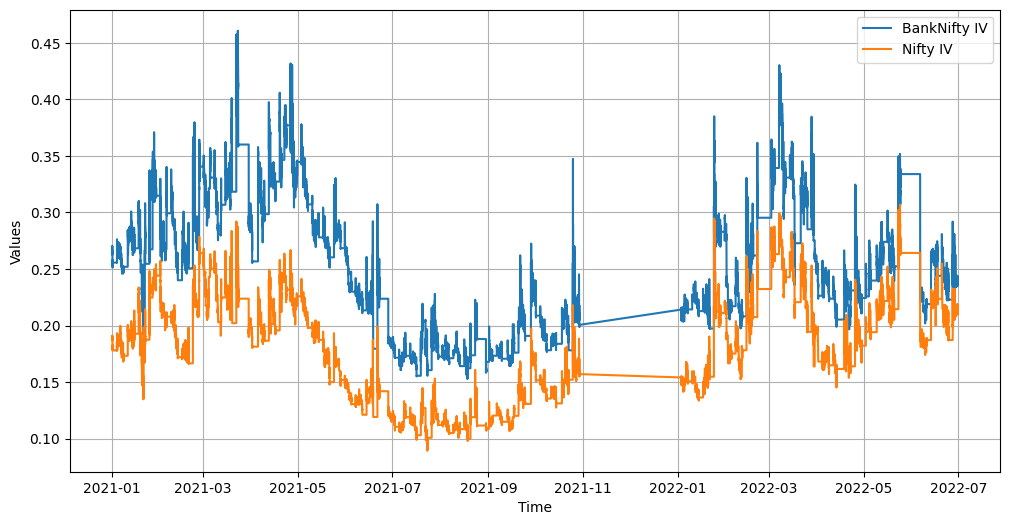

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(df['time'], df['banknifty'], label='BankNifty IV')
plt.plot(df['time'], df['nifty'], label='Nifty IV')
# plt.plot(df['time'], df['tte'], label='TTE')

plt.xlabel("Time")
plt.ylabel("Values")
plt.legend()
plt.grid(True)
plt.show()

In [28]:
class SpreadCalculator:
    def __init__(self, window=20):
        self.window = window

    def compute_spread(self, df):
        df['spread'] = df['banknifty'] - df['nifty']
        return df

    def compute_zscore(self, df):
        df['spread_mean'] = df['spread'].rolling(self.window).mean()
        df['spread_std']  = df['spread'].rolling(self.window).std()

        df['zscore'] = (df['spread'] - df['spread_mean']) / df['spread_std']
        df['zscore'] = df['zscore'].replace([np.inf, -np.inf], np.nan).fillna(0)
        return df

In [29]:
class PairTrade:
    def __init__(self, entry_time, entry_z, entry_spread, entry_mean, tte, direction):
        self.entry_time   = entry_time
        self.entry_z      = entry_z
        self.entry_spread = entry_spread
        self.entry_mean   = entry_mean
        self.tte          = tte
        self.direction    = direction

    def close(self, exit_time, exit_spread, exit_z, exit_mean):
        if self.direction == "LONG":
            pnl = exit_spread - self.entry_spread
        else:
            pnl = self.entry_spread - exit_spread

        self.exit_time   = exit_time
        self.exit_z      = exit_z
        self.exit_spread = exit_spread
        self.exit_mean   = exit_mean

        return pnl


In [31]:
from sklearn.mixture import GaussianMixture

class RegimeDetection:
    def __init__(self, n_regimes=3):
        self.n_regimes = n_regimes
        self.model     = GaussianMixture(n_components=n_regimes)

    def fit(self, features):
        labels = self.model.fit_predict(features)
        return labels

    def predict(self, features):
        return self.model.predict(features)

In [32]:
def build_regime_features(df, window=30):
    df['ret_bn'] = df['banknifty'].pct_change()
    df['ret_nf'] = df['nifty'].pct_change()

    df['spread_vol'] = df['spread'].rolling(window).std()
    df['z_vol']      = df['zscore'].rolling(window).std()

    features = df[['spread_vol', 'z_vol', 'ret_bn', 'ret_nf', 'zscore']].fillna(0)
    return features

In [33]:
class PairTradingStrategy:
    def __init__(self, upper, lower, exit_threshold, window,
                 bnIV_sl=None, nfIV_sl=None, allowed_regime=None):

        self.upper          = upper
        self.lower          = lower
        self.exit_mid       = (upper + lower) / 2
        self.bnIV_sl        = bnIV_sl
        self.nfIV_sl        = nfIV_sl
        self.allowed_regime = allowed_regime

        self.spread_model = SpreadCalculator(window)
        self.open_trade   = None
        self.ledger       = []

    def process(self, df):
        df = self.spread_model.compute_spread(df)
        df = self.spread_model.compute_zscore(df)

        for idx, row in df.iterrows():

            current_time = idx
            z            = row['zscore']
            spread       = row['spread']
            mean_val     = row['spread_mean']
            bankIV       = row['banknifty']
            niftyIV      = row['nifty']
            tte          = row['tte']
            regime       = row.get("regime", None)

            # ---------------------------------------------------------
            # ENTRY CONDITIONS
            # ---------------------------------------------------------
            if self.open_trade is None:

                #### Only trade during LOW-VOLATILITY regime
                if self.allowed_regime is not None:
                    if regime != self.allowed_regime:
                        continue

                # SHORT ENTRY (Z > UPPER BAND)
                if z > self.upper:
                    self.open_trade = PairTrade(
                        entry_time=current_time,
                        entry_z=z,
                        entry_spread=spread,
                        entry_mean=mean_val,
                        tte=tte,
                        direction="SHORT"
                    )

                # LONG ENTRY (Z < LOWER BAND)
                elif z < self.lower:
                    self.open_trade = PairTrade(
                        entry_time=current_time,
                        entry_z=z,
                        entry_spread=spread,
                        entry_mean=mean_val,
                        tte=tte,
                        direction="LONG"
                    )

            # ---------------------------------------------------------
            # EXIT CONDITIONS
            # ---------------------------------------------------------
            else:

                # Stop-Loss: High Implied Volatility
                if (self.bnIV_sl is not None and bankIV > self.bnIV_sl) or \
                   (self.nfIV_sl is not None and niftyIV > self.nfIV_sl):

                    pnl = self.open_trade.close(
                        exit_time=current_time,
                        exit_spread=spread,
                        exit_z=z,
                        exit_mean=mean_val
                    )

                    self.ledger.append(self._make_ledger_entry(current_time, spread, z, mean_val, pnl))
                    self.open_trade = None
                    continue

                # EXIT at mid-point (mean reversion)
                if self.open_trade.direction == "SHORT" and z <= self.exit_mid:
                    pnl = self.open_trade.close(
                        exit_time=current_time,
                        exit_spread=spread,
                        exit_z=z,
                        exit_mean=mean_val
                    )
                    self.ledger.append(self._make_ledger_entry(current_time, spread, z, mean_val, pnl))
                    self.open_trade = None

                elif self.open_trade.direction == "LONG" and z >= self.exit_mid:
                    pnl = self.open_trade.close(
                        exit_time=current_time,
                        exit_spread=spread,
                        exit_z=z,
                        exit_mean=mean_val
                    )
                    self.ledger.append(self._make_ledger_entry(current_time, spread, z, mean_val, pnl))
                    self.open_trade = None

        return pd.DataFrame(self.ledger)

    # ---------------------------------------------------------
    # Ledger Entry
    # ---------------------------------------------------------
    def _make_ledger_entry(self, exit_time, spread, z, mean_val, pnl):
        return {
            "entry_time": self.open_trade.entry_time,
            "exit_time": exit_time,
            "direction": self.open_trade.direction,

            "entry_spread": self.open_trade.entry_spread,
            "exit_spread": spread,

            "entry_zscore": self.open_trade.entry_z,
            "exit_zscore": z,

            "entry_mean": self.open_trade.entry_mean,
            "exit_mean": mean_val,

            "pnl": pnl
        }

In [35]:
# 1. Compute Spread + Zscores
sc = SpreadCalculator(window=30)
df = sc.compute_spread(df)
df = sc.compute_zscore(df)

# 2. Build ML Regime Features
features = build_regime_features(df, window=30)

# 3. Fit GMM
rd = RegimeDetection(n_regimes=3)
df["regime"] = rd.fit(features)

# 4. Find low-volatility regime cluster
low_vol_regime = df.groupby("regime")["spread_vol"].mean().idxmin()
print("Low volatility regime =", low_vol_regime)

# 5. Run Strategy
strategy = PairTradingStrategy(
    upper=0.5,
    lower=-0.5,
    exit_threshold=0.1,
    window=30,
    bnIV_sl=None,
    nfIV_sl=None,
    allowed_regime=low_vol_regime
)

ledger = strategy.process(df)
print(ledger)

Low volatility regime = 0
Empty DataFrame
Columns: []
Index: []


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def plot_pair_trading_time_range(df, ledger, start_time=None, end_time=None, regime_col="regime"):
    plt.style.use("ggplot")

    # -------------------------
    # Convert time index if needed
    # -------------------------
    if not isinstance(df.index, pd.DatetimeIndex):
        df['time'] = pd.to_datetime(df['time'])
        df = df.set_index('time')

    # -------------------------
    # Apply time filters
    # -------------------------
    if start_time is not None:
        start_time = pd.to_datetime(start_time)
        df = df[df.index >= start_time]

    if end_time is not None:
        end_time = pd.to_datetime(end_time)
        df = df[df.index <= end_time]

    # Filter ledger also
    ledger = ledger[
        (ledger["entry_time"] >= df.index.min()) &
        (ledger["exit_time"]  <= df.index.max())
    ]

    # -------------------------
    # Prepare figure
    # -------------------------
    fig, axs = plt.subplots(3, 1, figsize=(16, 12), sharex=True)

    # -------------------------
    # 1) SPREAD + REGIME SHADING
    # -------------------------
    axs[0].plot(df.index, df["spread"], label="Spread", linewidth=1.2)

    regimes = df[regime_col].unique()
    colors = plt.cm.tab20(np.linspace(0, 1, len(regimes)))

    for r, c in zip(regimes, colors):
        mask = df[regime_col] == r
        axs[0].fill_between(df.index,
                            df["spread"].min(),
                            df["spread"].max(),
                            where=mask,
                            color=c,
                            alpha=0.12)
    axs[0].set_title("Spread (With Regime Coloring)")
    axs[0].legend(loc="upper left")

    # -------------------------
    # 2) ZSCORE
    # -------------------------
    axs[1].plot(df.index, df["zscore"], label="Z-Score", linewidth=1.2)
    axs[1].axhline(1.26, color="red", linestyle="--", label="Upper Band 1.26")
    axs[1].axhline(-1.26, color="green", linestyle="--", label="Lower Band -1.26")
    axs[1].axhline(0, color="black", linewidth=0.8)

    axs[1].set_title("Z-Score (Time Selected)")
    axs[1].legend()

    # -------------------------
    # 3) TRADE MARKERS
    # -------------------------
    axs[2].plot(df.index, df["spread"], linewidth=1.0, label="Spread")

    for _, trade in ledger.iterrows():
        entry_t = trade["entry_time"]
        exit_t  = trade["exit_time"]
        entry_sp = trade["entry_spread"]
        exit_sp  = trade["exit_spread"]
        direction = trade["direction"]

        # Entry marker
        axs[2].scatter(entry_t, entry_sp,
                       color="blue" if direction=="LONG" else "red",
                       marker="^", s=90)
        axs[2].text(entry_t, entry_sp, f"{direction}", fontsize=8)

        # Exit marker
        axs[2].scatter(exit_t, exit_sp, color="black", marker="v", s=90)
        axs[2].text(exit_t, exit_sp, "EXIT", fontsize=8)

    axs[2].set_title("Trades (Time Selected)")
    axs[2].legend()

    plt.tight_layout()
    plt.show()


In [39]:
plot_pair_trading_time_range(
    df,
    ledger,
    start_time="2021-01-01 09:30",
    end_time="2021-01-01 11:00"
)


KeyError: 'entry_time'